#Player Popularity Analysis
The purpose of this part of the project is to find out what the characteristics are to look for in a player that is exceptional. For a person who is new to ultimate, it can be hard to know who to watch and why. In order to determine what players are actually popular, we first turned to twitter to extract player mentions. The Ultimate Frisbee community is very active on twitter, so this is generally a good forum to look at for news, since the sport is not usually televised. We then used Support Vector Machines and Decision Trees/Random Forests to make models for determining the factors that play into a player's twitter popularity.

The steps to this data analysis were as follows:
1. [Twitter Scraping](#Twitter-Scraping)
  * This part was very challenging, as the API was unhelpful for pulling all of the tweets for a query in the past year.
  * Note: this part takes ~30-50min to run, so I would suggest not running it! There are files in the repository to load with the results used for the analysis. See [Step 3](#End-of-Scraping).
2. [Name Matching](#Name-Matching)
  * Name matching was done using natural language processing implemented by the Stanford Name Entity Recognition Project
3. [Support Vector Machine](#Support-Vector-Machine)
4. [Decision Trees and Random Forests](#Decision-Trees-and-Random-Forests)
5. [Conclusions](#Conclusions)

##Twitter Scraping
The most challening part about the Twitter scraping was that the API was almost useless since it only goes back ~1-2weeks in its query results, which would have yielded less than 200 tweets.

The eventual solution was to use selenium in order to emulate scrolling down the page to retrieve more results.

In [744]:
%%time
from twython import Twython
from twython import TwythonError, TwythonRateLimitError, TwythonAuthError
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import time
import datetime
import csv
#import nltk
#import nltk.tag.stanford as st
import ner
import pandas as pd
import numpy as np
import re
from pandas import ExcelWriter
from collections import defaultdict
from fuzzywuzzy import fuzz,process
import unicodecsv

CPU times: user 47 µs, sys: 7 µs, total: 54 µs
Wall time: 51 µs


In [745]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [743]:
from matplotlib import rcParams
import statsmodels.api as sm

In [2]:
CONSUMER_KEY = ''
CONSUMER_SECRET =''
OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''

#auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,CONSUMER_KEY, CONSUMER_SECRET)
api = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

In [5]:
full_tweet_css = ".js-stream-item.stream-item.stream-item.expanding-stream-item"
tweet_text_css = ".TweetTextSize.js-tweet-text.tweet-text"
timestamp_css = '.tweet-timestamp.js-permalink.js-nav.js-tooltip'
quote_tweet_css = ".QuoteTweet-text.tweet-text.u-dir"
rt_css = '.ProfileTweet-action--retweet.u-hiddenVisually'
fav_css = ".ProfileTweet-action--favorite.u-hiddenVisually"
action_css = '.ProfileTweet-actionCount'

In [746]:
#Store team names
team_list_full = ["DC Breeze","Cincinnati Revolution","Chicago Fire","Charlotte Express",
             "Atlanta Hustle","Detroit Mechanix","INDIANAPOLIS ALLEYCATS","Jacksonville Cannons",
             "LOS ANGELES AVIATORS","MADISON RADICALS","MINNESOTA WIND CHILL","MONTREAL ROYAL",
             "NASHVILLE NIGHTWATCH","New York Empire","Ottawa Outlaws","PHILADELPHIA PHOENIX",
             "PITTSBURGH THUNDERBIRDS","Raleigh Flyers","Rochester Dragons","SAN DIEGO GROWLERS",
             "SAN FRANCISCO FLAMETHROWERS","SAN JOSE SPIDERS","SEATTLE CASCADES","TORONTO RUSH",
             "VANCOUVER RIPTIDE"]
team_list_full = [t.lower() for t in team_list_full]
team_cities = ["dc","cincinnati","chicago","charlotte","atlanta","detroit","indianapolis",
               "jacksonville","los angeles","madison","minnesota","montreal","nashville",
               "new york","ottawa","philadelphia","pittsburgh","raleigh","rochester",
               "san diego","san francisco","san jose","seattle","toronto","vancouver"]
team_names = ['breeze','revolution','fire','express','hustle','mechanix',
              'alleycats','cannons','aviators','radicals','wind chill','royal',
              'nightwatch','empire','outlaws','phoenix','thunderbirds','flyers',
              'dragons','growlers','flamethrowers','spiders','cascades','rush','riptide']
alt_name = ["dc","cincy","chicago","charlotte","atlanta","detroit","indy",
            "jax","la","madison","minnesota","montreal","nashville",
            "ny","ottawa","philly","pittsburgh","raleigh","rochester",
            "sd","sf","sj","seattle","toronto","vancouver"]
team_dict = dict(zip(team_cities, zip(team_names,alt_name)))


#### Function for retrieving tweets:

In [3]:
def get_tweets(query_str, min_unixtime):
    tweets = []
    driver = webdriver.Chrome()
    driver.set_window_size(500, 500)
    #pt2 = "%20until%3A2015-04-05&src=typd"
    url_to_get = "https://twitter.com/search?q=" + query_str #+ pt2
    print "URL TO GET: ", url_to_get
    #url_to_get = "https://twitter.com/search?q=" + query_str
    driver.get(url_to_get)
    
    while True:
        index = len(tweets)
        tweets_whole = driver.find_elements_by_css_selector(full_tweet_css)[index:]
        for elt in tweets_whole:
            # get tweet text
            try:
                t_text = elt.find_element_by_css_selector(tweet_text_css).text
            except NoSuchElementException:
                print "WARNING: No Text Element around: ", index
                t_text = "ERROR: no text element found"
            # get tweet timestamp
            try:
                t_unixtime = (int(elt.find_element_by_css_selector(timestamp_css)
                          .find_element_by_css_selector("span")
                          .get_attribute("data-time")))
            except NoSuchElementException:
                print "WARNING: No Time Element around: ", index
                #t_unixtime = elt.get_attribute('innerHTML')
                # defaults to 1/1/2016 (impossible, so it will show up as a red flag in the data)
                t_unixtime = 1451606400
            # get any quoted tweets within the tweet
            try:
                t_quote_text = elt.find_element_by_css_selector('.QuoteTweet-text.tweet-text.u-dir').text
                quote_tup = (t_quote_text, t_unixtime, 0)
                tweets.append(quote_tup)
            except NoSuchElementException:
                pass
            # get sum of RTs and favorites
            try:
                rts = (elt
                       .find_element_by_css_selector(rt_css)
                       .find_element_by_css_selector(action_css)
                       .get_attribute("data-tweet-stat-count"))
                favs = (elt
                       .find_element_by_css_selector(fav_css)
                       .find_element_by_css_selector(action_css)
                       .get_attribute("data-tweet-stat-count"))
                rts_plus_favs = int(rts) + int(favs)
            except NoSuchElementException:
                rts_plus_favs = 0
            tweet_tup = (t_text,t_unixtime,rts_plus_favs)
            tweets.append(tweet_tup)
        if int(tweets[-1][1]) < min_unixtime:
            print "FINISHED, WITH LAST TWEET AT: ", tweets[-1][1]
            driver.quit()
            return(tweets)
        print "Most Recent Unix Time: ", int(tweets[-1][1])
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
    driver.quit()

##WARNING: THE CODE BELOW TAKES A LONG TIME TO RUN

In [6]:
%%time
#tweets = get_tweets("audl", 1420070400)
tweet_grab = get_tweets("audl", 1420070400)

URL TO GET:  https://twitter.com/search?q=audl
Most Recent Unix Time:  1448982374
Most Recent Unix Time:  1448459812
Most Recent Unix Time:  1447700045
Most Recent Unix Time:  1447118607
Most Recent Unix Time:  1446677072
Most Recent Unix Time:  1446278132
Most Recent Unix Time:  1445969764
Most Recent Unix Time:  1444941006
Most Recent Unix Time:  1444351291
Most Recent Unix Time:  1444236727
Most Recent Unix Time:  1443645603
Most Recent Unix Time:  1443112062
Most Recent Unix Time:  1442591581
Most Recent Unix Time:  1442251047
Most Recent Unix Time:  1441740726
Most Recent Unix Time:  1441123319
Most Recent Unix Time:  1440874246
Most Recent Unix Time:  1440771014
Most Recent Unix Time:  1440628329
Most Recent Unix Time:  1440212327
Most Recent Unix Time:  1439959783
Most Recent Unix Time:  1439590362
Most Recent Unix Time:  1439333131
Most Recent Unix Time:  1439214343
Most Recent Unix Time:  1439162851
Most Recent Unix Time:  1439161113
Most Recent Unix Time:  1439152667
Most Rec

In [7]:
print len(tweet_grab)

2120


In [12]:
## Write to file
# with open('audl_tweets.csv','w') as out:
#     csv_out=csv.writer(out)
#     csv_out.writerow(['tweet_text','tweet_unixtime', 'tweet_popularity'])
#     for row in tweet_grab:
#         new_tup = (row[0].encode("utf8"), row[1], row[2])
#         csv_out.writerow(new_tup)

In [18]:
df = pd.read_excel('audl_tweets.xls')

In [19]:
df.shape

(2085, 3)

In [20]:
df.head()

,tweet_text,tweet_unixtime,tweet_popularity
0,Recruit Camp #1 tonight! http://cincinnatirevo...,1449359003,8
1,"Sin The Fields: Rochester Dragons, AUDL Advice...",1449262946,0
2,New STF! This time we tried the strategy of no...,1449258052,1
3,".@SinTheFields: Rochester Dragons, @theAUDL Ad...",1449257125,4
4,We're making the storyboard for the 2016 #AUDL...,1449180084,9


In [21]:
#take away new lines
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(r'\n',' ',x))

### Get the names of users
In each tweet that had a twitter handle (e.g. "This is a tweet by @jackiehmartinez"), we used the API to get the name of the user in order to replace it in the text of the tweet.

In [124]:
## Extract user mentions
def get_username_set(all_tweets_text):
    username_set = []
    for tweet_text in all_tweets_text:
        users = re.findall(r'@(\w+)', tweet_text)
        username_set.extend(users)
    #user_set = set(user_set)
    return set(username_set)
## Finds users' names based on list of usernames -- USES TWITTER API!!!
def get_names(usernames,twitter_instance):
    user_dict = {}
    indexes = range(0,len(usernames),100)
    indexes.append(len(usernames) - 1)
    for i in range(len(indexes) - 1):
        u_list = usernames[indexes[i]:indexes[i+1]]
        print (indexes[i]),(indexes[i+1])
        u_csv = ','.join(u_list)
        #print u_csv
        res_dicts = twitter_instance.lookup_user(screen_name = u_csv)
        for elt in res_dicts:
            user_dict[elt['screen_name'].lower()] =elt['name'].title()
    return user_dict



In [125]:
uname_set = get_username_set(df.tweet_text)

In [127]:
username_dict = get_names(list(uname_set),api)

0 100
100 200
200 300
300 400
400 441


In [128]:
len(username_dict.keys())

409

In [139]:
# Write Dictionary to File
w = csv.writer(open("username_dict.csv", "w"))
for key, val in username_dict.items():
    w.writerow([key, val.encode('utf-8')])

In [130]:
def replace_username(old_tweet,name_dict):
    for user in re.findall(r'@(\w+)', old_tweet):
        try:
            nm = name_dict[user.lower()]
        except KeyError:
            print "User not found: ", user
            nm = user
        old_tweet = re.sub(user,nm,old_tweet)
    nt = re.sub(r'@','',old_tweet)
    return(nt)

In [132]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: replace_username(x,username_dict))

User not found:  ditcheverything
User not found:  GDPJ_Meyer
User not found:  CincySaints
User not found:  charlotteexpress
User not found:  56ersNPSL
User not found:  charlotteaudl
User not found:  Bolton_Lava
User not found:  CharlotteAUDL


In [146]:
## Save work up to this point:
writer = ExcelWriter('audl_df.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

##Open Files from Directory
df: audl_df.xlsx

dictionary: username_dict.csv

roster: combined_dict_fixed.csv

player summaries: all_players.csv

#Name Matching

### Process tweets to get teams, names
In this section, we use natural language processing in order to match the names from the tweets with names that are in the data of player summaries, which came from the combined dataset of all games in 2015. One challenge here is that the AUDL has different names for each player than the player's actual name. For example, "Beau Kittredge" shows up in the dataset as "Kittre B". For this reason, we had to first match the players in the dataset with their actual names (scraped from teams' websites) and then use fuzzy string matching to find the closest match for a name mentioned in a tweet.

In [4]:
df = pd.read_excel('audl_df.xlsx')
username_dict = {}
reader = csv.reader(open("username_dict.csv"))
for row in reader:
    username_dict[row[0]]=row[1:]

In [498]:
# This is a dataset of rosters of players' full names 
all_rost = pd.read_csv('combined_dict_fixed.csv')

roster_byaudl = {}
roster_byfull = {}
for audl,full in zip(all_rost.audl_name,all_rost.full_name):
    roster_byaudl[audl.lower()] = full.lower()
    roster_byfull[full.lower()] = audl.lower()

In [7]:
not_names = ['audl','ultiworld','mlu','sotg']
def clean_tweets_2(t):
    potential_teams = []
    pat = ('|'.join(not_names))
    t = re.sub('(?i)'+pat,'',t)
    t = re.sub('#','',t)
    for k,v in team_dict.iteritems():
        if k in t.lower() or v[0] in t.lower() or (' ' + v[1] + ' ') in t.lower():
            pat = '|'.join([k,v[0],(' ' + v[1] + ' ')])
            t = re.sub('(?i)' + pat,'',t)
            potential_teams.append(k)
    return (potential_teams,t)

In [8]:
res_clean = df['tweet_text'].apply(clean_tweets_2)
df['clean'] = [twt for (team,twt) in res_clean]
df['poss_team'] = [team for (team,twt) in res_clean]


In [9]:
df.head()

,tweet_text,tweet_unixtime,tweet_popularity,clean,poss_team
0,Recruit Camp #1 tonight! http://cincinnatirevo...,1449359003,8,Recruit Camp 1 tonight! http://.com/2016--tryo...,[cincinnati]
1,"Sin The Fields: Rochester Dragons, AUDL Advice...",1449262946,0,"Sin The Fields:, Advice, & Reader Mail http:/...",[rochester]
2,New STF! This time we tried the strategy of no...,1449258052,1,New STF! This time we tried the strategy of no...,[rochester]
3,".Sinthefields: Rochester Dragons, Audl Advice,...",1449257125,4,".Sinthefields:, Advice, & Reader Mail: http:/...",[rochester]
4,We're making the storyboard for the 2016 #AUDL...,1449180084,9,We're making the storyboard for the 2016 mag....,[]


### Extract Player Names

Run in different terminal before executing code below (from directory that has stanford NER)

java -mx1000m -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer \
    -loadClassifier classifiers/english.all.3class.caseless.distsim.crf.ser.gz \
    -port 8080 -outputFormat inlineXML

In [10]:
tagger = ner.SocketNER(host='localhost', port=8080)

In [11]:
def process_tweet(twt,pop,poss_team,dpop,dteam):
    try:
        persons = tagger.get_entities(twt)['PERSON']
    except KeyError:
        persons = []
    for p in persons:
        if len(p.split()) == 4:
            if p.split()[0] == p.split()[2] and p.split()[1]==p.split()[3]:
                p = ' '.join(p.split()[0:2])
        dpop[p.lower()] += pop + 1
        dteam[p.lower()].extend(poss_team)

In [12]:
name_dict =  defaultdict(int)
poss_team_dict = defaultdict(list)
#apply function over dataframe to modify dictionary
dummy_var = df.apply(lambda r: process_tweet(r.clean, r.tweet_popularity, r.poss_team
                                             ,name_dict, poss_team_dict)
                     ,axis=1)


In [468]:
sorted(name_dict.items(), key=lambda x:x[1], reverse=True)[0:5]

[(u'brodie smith', 190),
 (u'beau kittredge', 159),
 (u'evan lepler', 157),
 (u'silverman', 90),
 (u'audrey larson', 85)]

#### Match names on roster

In [484]:
one_name = {}
two_name = defaultdict(int)
n_name = {}
choices = roster_byfull.keys()

for k,v in name_dict.iteritems():
    if len(k.split()) == 2:
        try:
            match = process.extract(k,choices,limit=2)
        except UnicodeDecodeError:
            print "unicode decode error"
            match = (k,0)
        if match[0][1]>95:
            two_name[match[0][0]] += v
            
#     elif len(k.split()) % 2 == 0 and len(k.split()) > 2:
#         interval = range(0,len(k),2)
#         for i,intval in enumerate(interval):
            
#         two_name[k] = v
#     elif len(k.split()) > 2:
#         n_name[k] = v
#     else:
#         print "Error"

In [489]:
# w = csv.writer(open("res_twitter_dict.csv", "w"))
# for key, val in two_name.items():
#     w.writerow([key, val])

In [493]:
print len(two_name), np.sum(two_name.values())

110 1829


In [250]:
two_name = {}
reader = csv.reader(open("res_twitter_dict.csv"))
for row in reader:
    two_name_dict[row[0]]=int(row[1])

In [496]:
print len(two_name_dict), np.sum(two_name_dict.values())

110 1829


## End of Scraping
#Support Vector Machine

We first tried a SVM to see if there were actually statistically significant methods of classifying players into "popular" or not "popular" in data that is multi-dimensional. We ended up making "popularity" a binary variable (1 if ever mentioned and 0 if never mentioned) because less than 25% of the players are ever mentioned on twitter.

To start, here are some functions that we used over the course of the semester to aid in learning models.
These functions were taken from lab7

In [752]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions from last lab
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.4f" % (training_accuracy)
    print "Accuracy on test data:     %0.4f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)

In [753]:
play_sum = pd.read_csv('all_players.csv')
play_sum.columns = ['name',u'team', u'goals', u'assists', u'ds', u'throwaways'
                    ,u'drops', u'opoints', u'dpoints', u'totalpoints'
                    , u'pct_opoints', u'pct_goal', u'pct_assist', u'pct_d', u'goal_percentile'
                    , u'assist_percentile', u'cluster']
play_sum['name'] = play_sum['name'].apply(lambda x: x.lower())

In order to simplify things for the SVM, separate the categorical variable "cluster" into five binary variables. This cluster variable was taken from the clustering analysis done earlier.

In [754]:
for pos in list(set(play_sum.cluster)):
    print pos
    play_sum[pos] = play_sum['cluster'].apply(lambda x: (x==pos) * 1)

o_handler
o_cutter
d_handler
d_cutter
d_roleplayer


In [755]:
def to_roster_name(name,roster):
    try: n = roster[name]
    except KeyError: n = 'none'
    return n.lower()

def get_pop(name, roster,binary=True):
    try:
        r = roster[name]
        if binary: res = (r > 0) * 1
        else: res = r
    except KeyError: res = 0
    return res

In [756]:
# get full names from roster
play_sum['full_name'] = play_sum['name'].apply(lambda x: to_roster_name(x,roster_byaudl))

In [757]:
# match roster names and df names to get a boolean variable and integer variable for twitter mentions
play_sum['b_twitter'] = play_sum['full_name'].apply(lambda x: get_pop(x, two_name,binary=True))
play_sum['n_twitter'] = play_sum['full_name'].apply(lambda x: get_pop(x, two_name,binary=False))

In [758]:
print np.sum(play_sum['b_twitter']), np.sum(play_sum['n_twitter'])

110 1829


In [759]:
# Variables that can be standardized
STANDARDIZABLE = [u'goals', u'assists', u'ds', u'throwaways', u'drops',
                  u'opoints', u'dpoints',u'totalpoints']
INDICATORS = ['o_handler', 'o_cutter', 'd_handler', 'd_cutter', 'd_roleplayer']
# All predictor variables (none are indicator)
lcols = STANDARDIZABLE + INDICATORS + ([u'pct_opoints', u'pct_goal', u'pct_assist', u'pct_d',
                               u'goal_percentile', u'assist_percentile'])
dftouse = play_sum

The code in the cells below below begins the implentation of the SVM by splitting it up into test and training sets.

In [760]:
# Set up test and training sets
# NOTE: We standardize the whole set (test & train), but will create the standardizer based on only the training set.
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

The next step is to standardize the standardizeable variables.

In [761]:
from sklearn.preprocessing import StandardScaler
for col in STANDARDIZABLE:
    #print col
    valstrain=dftouse[col].values[mask]
    valstest=dftouse[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    # Must fit the scaler to this data first!
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

As we can see from the plots below, there is no clear division in a variable for popular and not popular players, so further analysis is needed

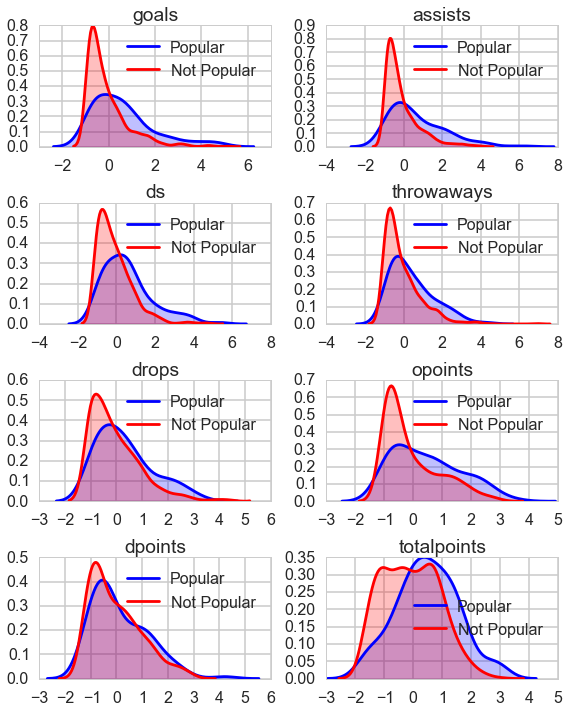

In [762]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 10), 
                         tight_layout=True)
for ax, cc in zip(axes.ravel(), ccols):
    sns.kdeplot(dftouse[dftouse["b_twitter"]==1][cc], ax=ax, c='b', shade=True, label = "Popular")
    sns.kdeplot(dftouse[dftouse["b_twitter"]==0][cc], ax=ax, c='r', shade=True, label="Not Popular")
    ax.set_title(cc)

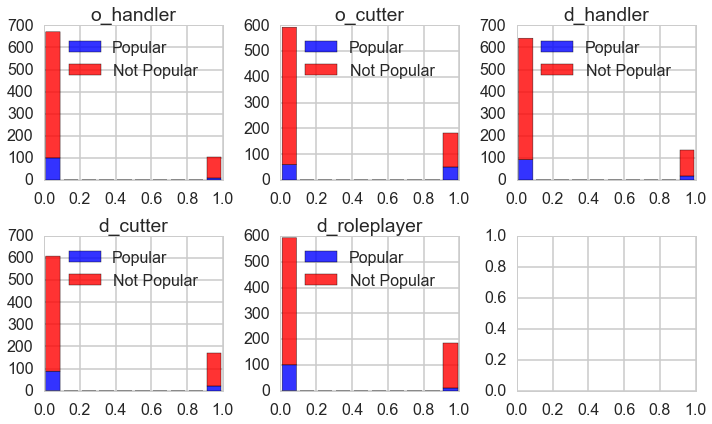

In [764]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), 
                         tight_layout=True)
for ax, ind in zip(axes.ravel(), INDICATOR):
    #dftouse[ind].hist(ax=ax, c)
    ax.hist([dftouse[dftouse["b_twitter"]==1][ind], dftouse[dftouse["b_twitter"]==0][ind]],stacked=True, color = ['b','r'], label=['Popular', 'Not Popular'], alpha = 0.8)
    ax.set_title(ind)
    ax.legend(loc='upper center')

In [765]:
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)
print len(ccols), len(INDICATORS)
#ccols

14 5


In [773]:
from sklearn.svm import LinearSVC
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=dftouse[ccols].values
Yresp=dftouse['b_twitter'].values

In [774]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [775]:
from sklearn.grid_search import GridSearchCV
parameters = {"C":Cs}
gridclassifier=GridSearchCV(clfsvm, param_grid=parameters, cv=5, scoring="accuracy")
gridclassifier.fit(Xmatrix_train, Yresp_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

In [776]:
best_c = gridclassifier.best_params_
best_sc = gridclassifier.best_score_
best = gridclassifier.best_estimator_
print best_c
print best_sc
print best

{'C': 0.1}
0.861878453039
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [777]:
new_clfsvm = best.fit(Xmatrix_train, Yresp_train)
new_clfsvm.score(Xmatrix_train, Yresp_train)

0.85451197053407002

In [778]:
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, u'b_twitter',1, mask=mask)

using mask
BEST {'C': 0.01} 0.858195211786 [mean: 0.79190, std: 0.11655, params: {'C': 0.001}, mean: 0.85820, std: 0.00715, params: {'C': 0.01}, mean: 0.85820, std: 0.00715, params: {'C': 0.1}, mean: 0.81400, std: 0.08143, params: {'C': 1.0}, mean: 0.79006, std: 0.12913, params: {'C': 10.0}, mean: 0.76427, std: 0.17297, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.8545
Accuracy on test data:     0.8675
[[203   0]
 [ 31   0]]
########################################################


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [779]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [780]:
print "whole data set", dftouse['b_twitter'].mean()#Highly asymmetric
print "training set", dftouse['b_twitter'][mask].mean(), "test set", dftouse['b_twitter'][~mask].mean()


whole data set 0.14157014157
training set 0.145488029466 test set 0.132478632479


##SVM Conclusions
So, given that only 14.15% of our results are twitter mentions anyway, the baseline model will be one that predicts that no one is popular and thus has 85.85% accuracy. This is higher than model's accuracy on the test data, so the baseline in this case is much better. Still, a model that has 85% accuracy definitely means that there are important features to look at. Below, there is a confusion matrix that shows that the results from the 86% accurate SVM actually had no false positives or negatives.

In [781]:
ypred=clfsvm.predict(Xtest)
confusion_matrix(ytest, ypred)

array([[203,   0],
       [ 31,   0]])

#DecisionTrees and Random Forests
Because the SVM was not a significant improvement from the baseline model, we decided to also implement a random forest. The second thing to note is that it is hard to extract important features from a SVM since it is n-dimension and creates hyperplanes based on that. It is much easier to garner ideas about what are the things to look for in a player that may mean they are popular. Generally, the goal was to see if any of the forest models had accuracy greater than or equal to the 85%.

Following the process from lab 7 on wine classification.
https://github.com/cs109/2015lab7/blob/master/Lab7-Botany%20and%20Ensemble%20Methods.ipynb

In [782]:
Xnames = lcols

In [783]:
np.mean(dftouse.b_twitter)

0.14157014157014158

In [711]:
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.6)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [712]:
#Ensure that the test and training sets are sufficiently similar to the whole set
print "% b_twitter in Training:", np.mean(dftouse.b_twitter[mask])
print "% b_twitter in Testing:", np.mean(dftouse.b_twitter[~mask])


% b_twitter in Training: 0.141630901288
% b_twitter in Testing: 0.141479099678


In [722]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, dftouse, 
                                                     Xnames,'b_twitter', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 5, 'min_samples_leaf': 1} 0.097824896075 [mean: 0.05945, std: 0.11789, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.05945, std: 0.11789, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.05945, std: 0.11789, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.05945, std: 0.11789, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.05945, std: 0.11789, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.05945, std: 0.11789, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.05945, std: 0.11789, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.05945, std: 0.11789, params: {'max_depth': 2, 'min_samples_leaf': 2}, mean: 0.05945, std: 0.11789, params: {'max_depth': 2, 'min_samples_leaf': 3}, mean: 0.05945, std: 0.11789, params: {'max_depth': 2, 'min_samples_leaf': 4}, mean: 0.05945, std: 0.11789, params: {'max_depth': 2, 'min_samples_leaf': 5}, mean: 0.05945, std: 0.11789, params: {'max_depth': 2, 'min_samples_leaf': 6}, mea

/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  


It looks like the decision tree suffered from overfitting since the accuracy on the training set was 91% and on the test set was 85%. This model is just as accurate than the SVM, which is slightly more accurate than the baseline!

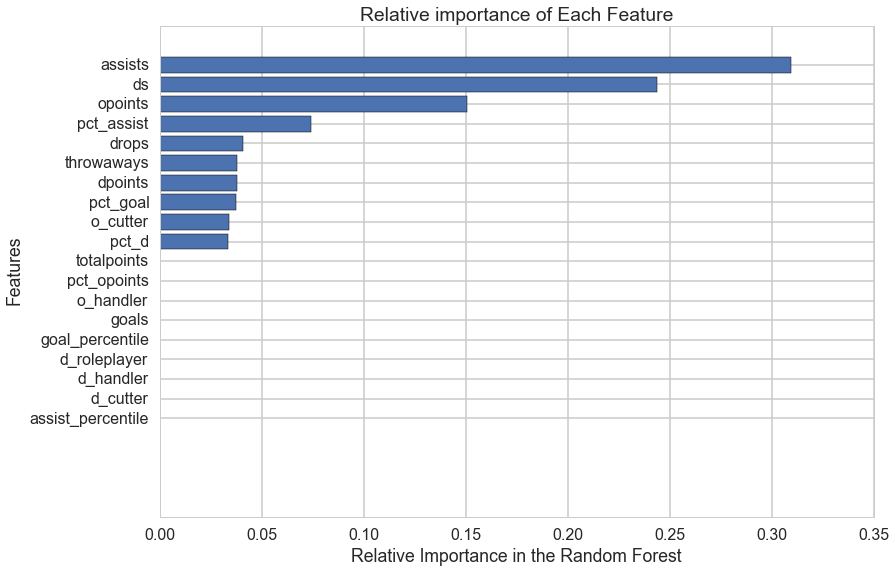

In [784]:
importance_list = clfTree1.feature_importances_
name_list = Xnames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

This is one of the most useful graphics for what we're trying to do. It is apparent that assists and ds make a very popular player.

In [793]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 10)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       dftouse, Xnames, 'b_twitter', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 2} 0.131275395364 [mean: 0.11087, std: 0.08893, params: {'n_estimators': 1}, mean: 0.13128, std: 0.16671, params: {'n_estimators': 2}, mean: 0.08365, std: 0.11064, params: {'n_estimators': 3}, mean: 0.08309, std: 0.11607, params: {'n_estimators': 4}, mean: 0.06881, std: 0.11528, params: {'n_estimators': 5}, mean: 0.10762, std: 0.13566, params: {'n_estimators': 6}, mean: 0.07091, std: 0.12114, params: {'n_estimators': 7}, mean: 0.07557, std: 0.10609, params: {'n_estimators': 8}, mean: 0.07985, std: 0.10590, params: {'n_estimators': 9}]
############# based on standard predict ################
Accuracy on training data: 0.9227
Accuracy on test data:     0.8547
[[199   4]
 [ 30   1]]
########################################################


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  


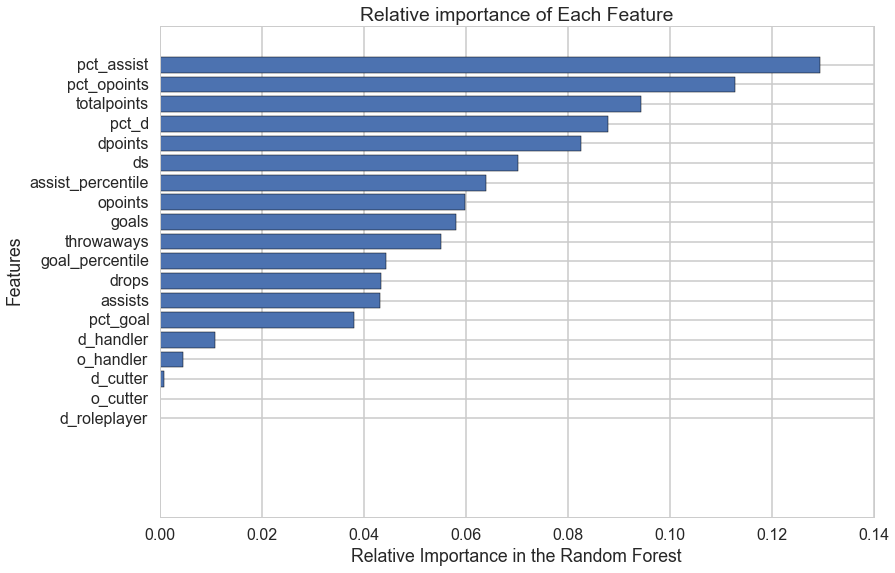

In [794]:
importance_list = clfForest.feature_importances_
name_list = Xnames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [795]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(1, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       dftouse, Xnames, 'b_twitter', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 1} 0.086299303387 [mean: 0.08630, std: 0.10846, params: {'n_estimators': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 2}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 3}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 4}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 5}, mean: 0.08630, std: 0.10846, params: {'n_estimators': 6}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 7}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 8}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 9}, mean: 0.08484, std: 0.10732, params: {'n_estimators': 10}, mean: 0.07051, std: 0.09993, params: {'n_estimators': 11}, mean: 0.07051, std: 0.09993, params: {'n_estimators': 12}, mean: 0.07051, std: 0.09993, params: {'n_estimators': 13}, mean: 0.07051, std: 0.09993, params: {'n_estimators': 14}, mean: 0.07146, std: 0.10019, params: {'n_estimators': 15}, mean: 0.07838, std: 0.09555, params: {'n_estimators': 16}, mean: 0.07051, std: 0.09

/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  


This ADA Boost Classifier is by far the best classifier we have so far, with an accuracy of 86.75%. The AdaBoost is helpful because plays around with different weights for the data and then uses those to create trees in the same way a random forest does. Points that are predicted incorrectly get higher weights, since the ADA Classifier measures weighted lost. We see in the visual below that the ADA Classifier only takes assists into account and is able to build a simple model on that

In [799]:
clfAda.feature_importances_

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

In [800]:
#print clfForest.feature_importances_.argsort()[::-1][0:2]

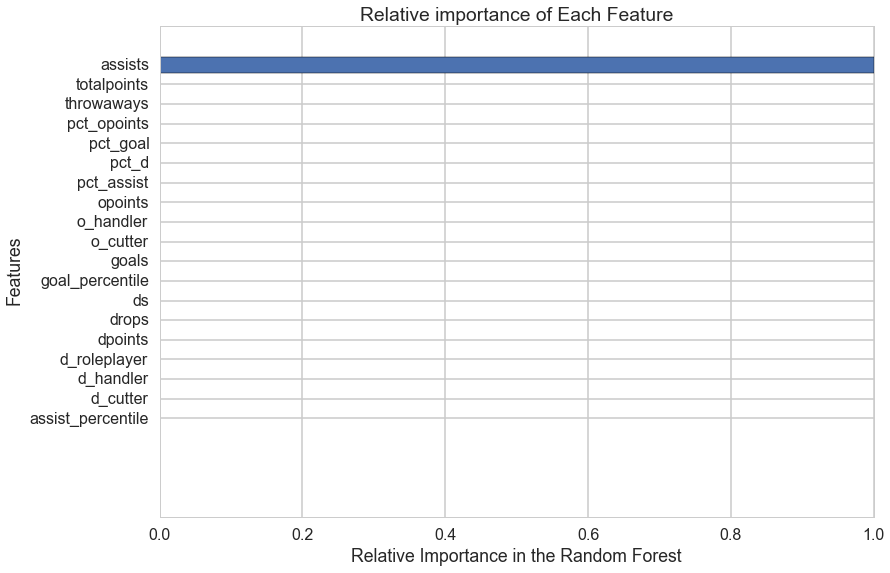

In [801]:
importance_list = clfAda.feature_importances_
name_list = Xnames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
#plt.xlim(0,5)
plt.title('Relative importance of Each Feature')
plt.show()

In [802]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       dftouse, Xnames, 'b_twitter', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 31, 'max_depth': 3} 0.0836777601403 [mean: 0.05139, std: 0.10240, params: {'n_estimators': 30, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 31, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 32, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 33, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 34, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 35, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 36, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 37, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 38, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 39, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_estimators': 40, 'max_depth': 1}, mean: 0.07500, std: 0.10144, params: {'n_estimators': 41, 'max_depth': 1}, mean: 0.05139, std: 0.10240, params: {'n_

/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  
/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  


This classifier, while not as good as the ADA Boosting, was still better than the baseline.

In [803]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]

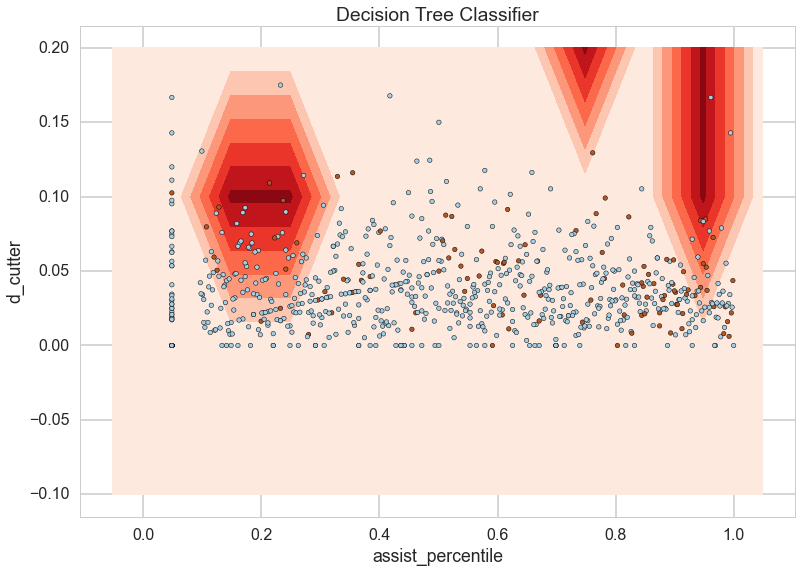

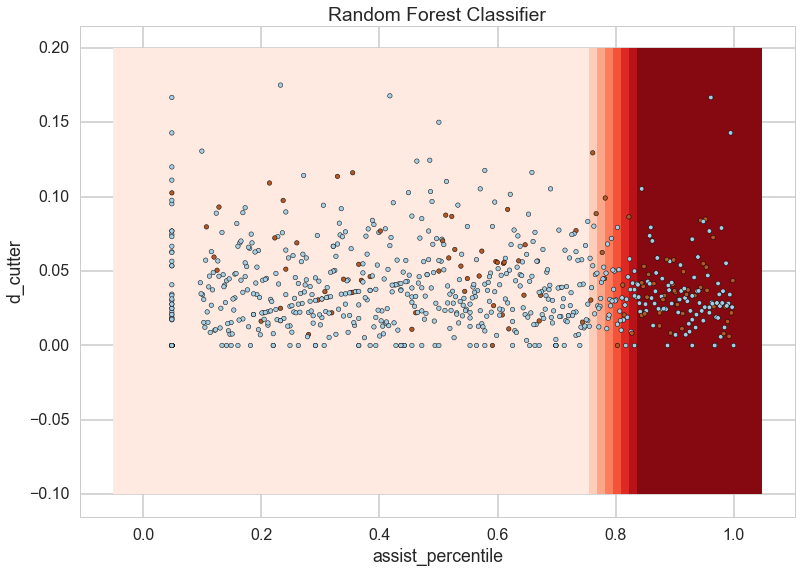

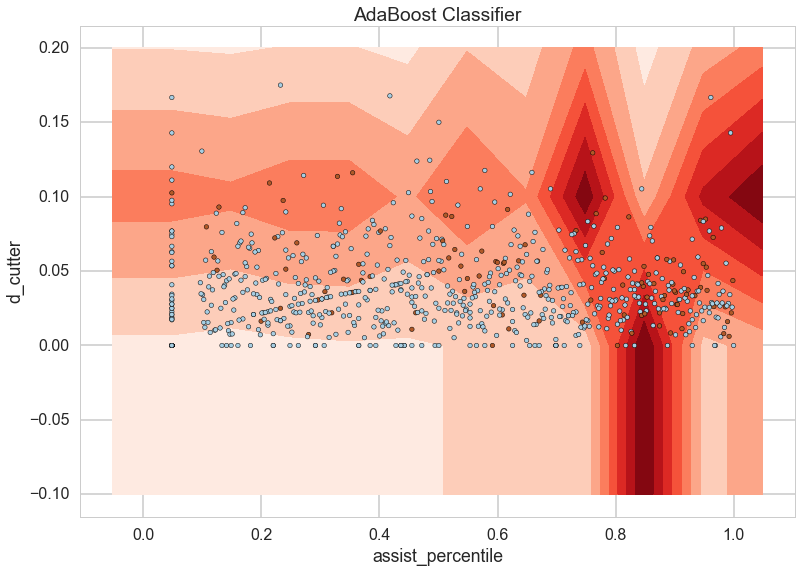

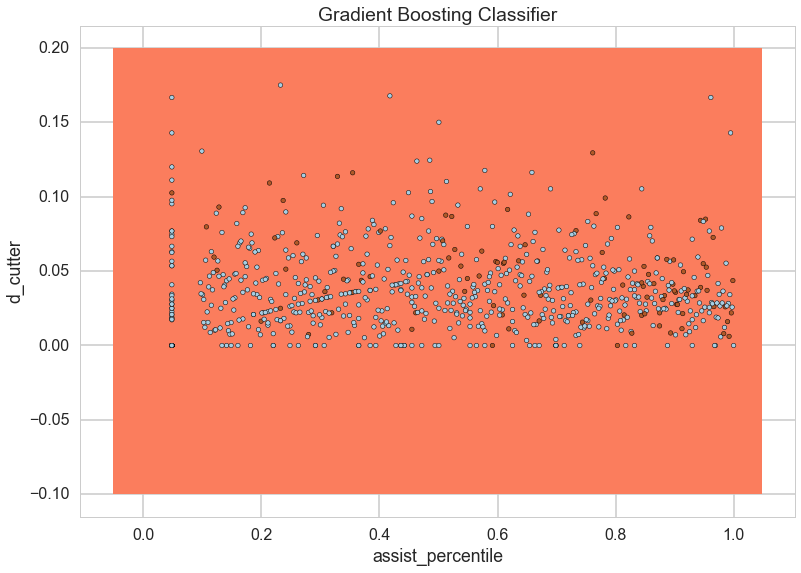

IndexError: list index out of range

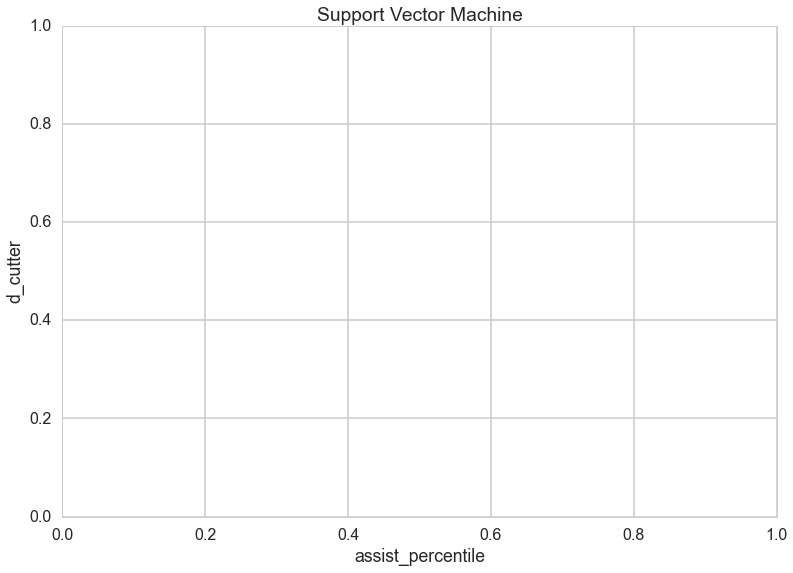

In [804]:
X_imp = dftouse[imp_cols].values
Y = dftouse.b_twitter.values

classifiers = [clfForest,
               clfAda,
               clfGB,
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Support Vector Machine']
for c in xrange(5):
    plt.title(titleClassifer[c])
    plt.xlabel(name_list[0])
    plt.ylabel(name_list[1])
    plot_decision_surface(classifiers[c], X_imp, dftouse.b_twitter.values)

#Conclusions

The goal of the twitter analysis was to figure out what makes a "highlight" player. The majority of the work here happened in the actual scraping, matching, and cleaning. After that, we were able to create some interesting models using Support Vector Machines and Random Forests. The best model ended up coming from an Adaptive Boosting Decision tree.

Even though the models were relatively accurate (all were around ~85%), none of them were had >1% improvement over the baseline model. This suggests that there are still some variables necessary for looking at player popularity via twitter. We were able to see the importance of assists and Ds in highlight players.

Analysis for the future would include getting popularity as a continuous variable rather than a binary variable to see if, for players that ARE mentioned, certain characteristics are more important for determining the level of popularity.